## Analysis of stock prices using PCA

In this Notebook we analyze the prices of stocks in the S&P500.

The notebook consists of 3 parts: data loading, PCA analysis column-wise and PCA analysis row wise.

In [1]:
import sys,os
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

from time import time
import math
import pandas as pd
from glob import glob
import pickle


###Data Loading
The data is in a tar file on S3. Download and untar the file and then execute the following cells.

In [6]:
#change this path to where you stored the raw data
# Data_dir='/Users/yoavfreund/BigData/stocksDataset/spdata_csv/'
Data_dir='/Users/qinming/iPythonNotebook/UCSD_BigData_2015/notebooks/SP500/spdata_csv'
curr_dir=os.getcwd()
curr_dir

'/Users/qinming/iPythonNotebook/UCSD_BigData_2015/notebooks/SP500'

In [88]:
# Load the files into pandas DataFrame
%cd $Data_dir
Tables={}
for filename in glob('*.csv'):
    #print filename
    tbl=pd.read_csv(filename,index_col='Date',parse_dates=True)
    code = filename[:-4]
    if(np.shape(tbl)[1]==12):
        Tables[code]=tbl.sort_index()
        Tables[code]
    else:
        print filename,np.shape(tbl)

%cd $curr_dir

/Users/qinming/iPythonNotebook/UCSD_BigData_2015/notebooks/SP500/spdata_csv
/Users/qinming/iPythonNotebook/UCSD_BigData_2015/notebooks/SP500


### Pre-Processing
In the following code we perform the following pre-processing steps:

1. **Removing outliers** (choosing which ones is based on later steps)
2. **Correcting for splits:** stocks are sometimes split into smaller denominations. These splits have to be accounted for in order to get a continuous price line without jumps.
3. **Computing diffs:** It is more meaningful to predict *changes* in prices than prices themselves. We therefor compute for each stock a `Diffs` sequence in which $d(t)=\log \frac{p(t+1)}{p(t)}$ where $p(t)$ is the price at time $t$ and $d(t)$ is the price diff or the price ratio.

In [13]:
Daily=pd.DataFrame()
Diffs=pd.DataFrame()
#print np.shape(SR)
Indices=set(Tables.keys()) #list
# Remove the following lines to process all stocks. Plot the PCA and the time sequences of these stocks 
# to see why they are outliers and need to be removed.
Indices=Indices - set([u'LIFE', u'PGR', u'HAS',u'UNM'])  #remove outlier stock - most likely due to file errors
for code in Indices:
    tbl=Tables[code]
    SR=tbl['Split Ratio']   # incorporate split ratios of stock
    CSR=np.cumsum(SR.apply(math.log)).apply(math.exp)
    S=np.multiply(tbl['Open'],CSR)
    S=S/S.mean()
    SasDataFrame=pd.DataFrame(data={code:S})
    # The pandas Series S will be merged into Daily according to the indices.
    Daily=Daily.join(SasDataFrame,how='outer')       
    prices=np.array(S)  # The length of "prices" will remain the original length.
    diff=np.log(prices[1:]/prices[:-1])
    I=S.index
    I=I[1:]
    #print np.shae(Diffs),np.shape(Sdiff),np.shape(diff),len(I)
    Sdiff=pd.DataFrame(diff,index=I,columns=[code])
    Diffs=Diffs.join(Sdiff,how='outer')

In [ ]:
# plot some stocks
Daily[['AAPL','MSFT','GOOG','IBM']].plot(figsize=(14,10))


### Pickling and unpickling
The preprocessing steps take a significant amount of time. Instead of redoing these steps each time
you start the iPython kernel. You can pickle the results into a file and load this file again in later runs, skipping the preprocessing step

In [15]:
pickle.dump({'Daily':Daily,'Diffs':Diffs},open('DailyDiffs.pkl','wb'))

In [16]:
PD=pickle.load(open('DailyDiffs.pkl','rb'))

In [17]:
Daily=PD['Daily']
Diffs=PD['Diffs']

## Create a color map by sector to which the stock belongs

In [141]:
colorMap0 = [
'#000000',
'#FF0000',
'#800000',
'#FFFF00',
'#808000',
'#00FF00',
'#008000',
'#00FFFF',
'#008080',
'#0000FF',
'#000080',
'#FF00FF',
'#800080']
constituent = None
constituent=pd.read_csv('constituents_Lu.csv',index_col='Symbol')
sector = constituent['Sector']
colormap1 = {}
assign = 0
for sec in sector :
    if not (sec in colormap1):
        colormap1[sec] = assign
        assign += 1
colorMap = {}
for code, sec in enumerate(sector):
    colorMap[sector.index[code]] = colorMap0[colormap1[sec]]

### PCA1
####Eigen-vectors correspond to time sequences
In the following steps we perform of the `Diffs` matrix column wise. The result is a set of eigen-vectors whose dimension is the total number of trading days (13422)

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30)
diffs_matrix=np.transpose(np.array(Diffs.fillna(0)))# fill N/A with 0
pca.fit(diffs_matrix)
eigen_vecs=pca.components_
np.shape(eigen_vecs), np.shape(Diffs), np.shape(diffs_matrix)

((30, 13422), (13422, 481), (481, 13422))

individual percent explained:
[ 0.05394363  0.03376526  0.02902396  0.02541831  0.0158646   0.01288044
  0.01159089  0.01117823  0.00803385  0.00785751  0.00756604  0.00717943
  0.00694791  0.00682839  0.0063986   0.00627153  0.00607661  0.0058404
  0.00568517  0.00553848  0.00549541  0.00541794  0.00525759  0.00512936
  0.00511184  0.00500667  0.00488102  0.00483066  0.00473514  0.00470256]
cumulative percent explained:
[ 0.05394363  0.08770889  0.11673285  0.14215116  0.15801575  0.1708962
  0.18248708  0.19366531  0.20169916  0.20955667  0.21712272  0.22430215
  0.23125006  0.23807845  0.24447705  0.25074858  0.25682519  0.26266559
  0.26835076  0.27388924  0.27938465  0.28480259  0.29006018  0.29518954
  0.30030138  0.30530805  0.31018907  0.31501973  0.31975487  0.32445744]


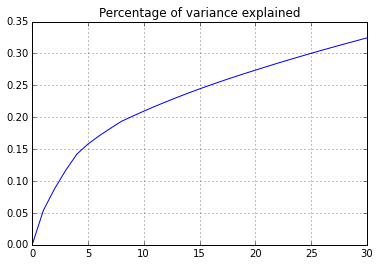

In [25]:
# check how much of the variance is explained by the top eigenvectors.
print 'individual percent explained:\n',pca.explained_variance_ratio_
print 'cumulative percent explained:\n',np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.cumsum(np.concatenate([np.array([0]),pca.explained_variance_ratio_])))
plt.grid()
plt.title('Percentage of variance explained')

In [26]:
tdf = pca.transform(diffs_matrix)  # compute the projections of the stocks on the eigen-values
np.shape(tdf)

(481, 30)

In [143]:
# Generate the scatter plot of the stocks on a pair of eigen-vectors defined by i0,i1
i0=0;i1=1
# In order that the stock ticker names are readable we make the plot very large
fig, ax = plt.subplots(figsize=(20,20))  
plt.xlim([np.amin(tdf[:,i0]),np.amax(tdf[:,i0])])
plt.ylim([np.amin(tdf[:,i1]),np.amax(tdf[:,i1])])
plt.title('SP500 stocks scatter on '+str(i0)+', '+str(i1),fontsize=20)
names=Diffs.columns
for i in range(len(names)):
    ax.annotate(names[i], (tdf[i,i0],tdf[i,i1]),fontsize=5,color=colorMap[names[i]] )
# This very large plot is hard to view and manipulate inside the notebook. We therefor export it into a pdf file
fig.savefig('scatter'+str(i0)+str(i1)+'.pdf', format='PDF')
# After exporting, we clear the figure so that the plot does not appear in the notebook.
fig.clear()

### PCA2
####Eigen-vectors correspond to stock weightings.
In the following steps we perform of the `Diffs` matrix row wise. The result is a set of eigen-vectors 
whose dimension is the number of stocks (481)

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30)
diffs_matrix=np.array(Diffs.fillna(0))
pca.fit(diffs_matrix)
eigen_vecs=pca.components_
np.shape(eigen_vecs), np.shape(names)

((30, 481), (481,))

individual percent explained:
[ 0.21398827  0.03770126  0.02369833  0.02260537  0.01292739  0.01108481
  0.01011396  0.00910506  0.00817646  0.00644264  0.00614672  0.00597968
  0.00571326  0.00558592  0.00527333  0.00509926  0.00499056  0.00478962
  0.00470154  0.00460268  0.00448346  0.00442335  0.00426686  0.00419238
  0.00415919  0.00406939  0.00400249  0.00395228  0.00389476  0.00383117]
cumulative percent explained:
[ 0.21398827  0.25168953  0.27538785  0.29799322  0.31092061  0.32200542
  0.33211938  0.34122444  0.3494009   0.35584354  0.36199026  0.36796994
  0.3736832   0.37926912  0.38454245  0.38964172  0.39463228  0.3994219
  0.40412344  0.40872612  0.41320958  0.41763293  0.42189979  0.42609217
  0.43025136  0.43432075  0.43832324  0.44227552  0.44617028  0.45000145]


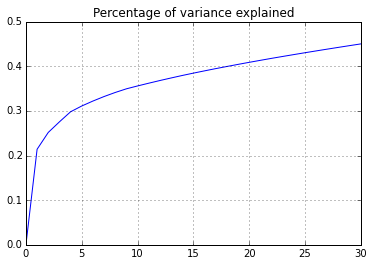

In [34]:
# check how much of the variance is explained by the top eigenvectors.
print 'individual percent explained:\n',pca.explained_variance_ratio_
print 'cumulative percent explained:\n',np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.cumsum(np.concatenate([np.array([0]),pca.explained_variance_ratio_])))
plt.grid()
plt.title('Percentage of variance explained')

**HW** in this case the first eigen-vector explains more that %21 of the variance. Can you give an interpretation to this vector? (Hint: look at the distribution of the coordinate values)

In [35]:
np.shape(eigen_vecs),np.shape(names)

((30, 481), (481,))

In [144]:
# Generate the scatter plot of the stocks on a pair of eigen-vectors defined by i0,i1
i0=1;i1=2
# In order that the stock ticker names are readable we make the plot very large
fig, ax = plt.subplots(figsize=(20,20))
plt.xlim([np.amin(eigen_vecs[i0,:]),np.amax(eigen_vecs[i0,:])])
plt.ylim([np.amin(eigen_vecs[i1,:]),np.amax(eigen_vecs[i1,:])])
plt.title('SP500 stocks scatter on '+str(i0)+', '+str(i1),fontsize=20)
names=Diffs.columns
for i in range(len(names)):
    ax.annotate(names[i], (eigen_vecs[i0,i],eigen_vecs[i1,i]),fontsize=5,color=colorMap[names[i]])
# This very large plot is hard to view and manipulate inside the notebook. We therefor export it into a pdf file
fig.savefig('scatter'+str(i0)+str(i1)+'PCA2.pdf', format='PDF')
# After exporting, we clear the figure so that the plot does not appear in the notebook.
fig.clear()

### Identifying outliers
Use these cells after you comment out the command above that removes the indices `set([u'LIFE', u'PGR', u'HAS',u'UNM'])`

In [17]:
## Identify the outliers 
## To make this really work, comment out the removed stocks when processing above: set([u'LIFE', u'PGR', u'HAS',u'UNM'])
mx=[0]*2
mn=[0]*2
Set=set()
names=Diffs.columns
for i in range(2):
    mx[i]=np.argmax(tdf[:,i])
    mn[i]=np.argmin(tdf[:,i])
    Set=Set.union(set([mn[i],mx[i]]))
for elem in Set:
    print names[elem],
    print tdf[elem,:2]

AMGN [-0.24826548 -0.51960331]
NEM [ 0.59058826 -0.0990569 ]
NTAP [-1.53421152 -0.25656284]
GNW [ 0.17344529  1.11112665]


In [18]:
#One of the bad sequences.
# Daily[[u'UNM']].plot(figsize=(14,10))

### HW

**Global analysis**
1. Use the information in the file `constituents.csv` to color code the stocks according to sector to which the stock belongs.
1. Use the online PCA method to find the local eigen-vectors corresponding to PCA2 (Row wise analysis, generating vectors whose dimension is the number of stocks). Use an $\alpha$ value that corresponds to 10 years.
1. generate the coloring as above for the projection on the top two eigen-vectors corresponding to 1970,1980,1990,2000,2010.

**local analysis**
1. You should have recieved a ticker symbol in email from the TA. The ticker symbol corresponds to a company that has been in existance for the last 50 years or more. Use wikipedia, Yahoo! etc. to compile a paragraph on the company and it's history.
1. Using the projection on the top 20 eigenvectors, identify the 10 companies that are closest (using euclidean distance) to your company.
1. Repeat the same for each one of the 10-year PCA projections for each 10 years from 1970 to 2010 (see above).
1. Generate a plot of the price of your stock, and it's related stocks as a function of time. Figure out some way (scaling, chopping the time line, taking logs etc.) that the performance of the stocks can be compared for the whole time in which your stock was in existence.
1. Using Wikipedia etc. find out a description of the neighboring companies.
2. Based on the description, give a narrative describing the location of the company in the context of it's neighbor companies. In what ways is it similar to it's neighbors and in what ways it is unique. Are there any companies that are competitors? Suppliers? Buyers?
How did it's location change over the time of it's existance. Write this description in a markdown cell.

**Extra credit**
* Use [Plotly](https://plot.ly/) to create a dynamic scatter-plot which can be navigated (pan and zoom) and where clicking on each ticker brings up information about that stock.
* Figure out the meaning of the "adjusted" columns in the original tables and find out if they are better/worse/similar for PCA analysis.

HW in this case the first eigen-vector explains more that %21 of the variance. Can you give an interpretation to this vector? (Hint: look at the distribution of the coordinate values)

In [100]:
[(i,x) for i,x in enumerate(Tables['PCG']['Split Ratio']) if x!=1]

[(2809, 2.0)]